# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [38]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [39]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [40]:
import numpy as np
np.random.normal(10,2)

10.285812150672564

In [41]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=534.4034852015398, mobile=True), User(purchased=True, time_on_site=519.531555913399, mobile=True), User(purchased=True, time_on_site=388.26194028252405, mobile=True), User(purchased=False, time_on_site=304.6439002510085, mobile=True), User(purchased=False, time_on_site=187.9184527922469, mobile=True), User(purchased=False, time_on_site=353.34988794273454, mobile=True), User(purchased=True, time_on_site=393.5981653559758, mobile=True), User(purchased=True, time_on_site=470.2695114302952, mobile=True), User(purchased=False, time_on_site=326.54817984247666, mobile=True), User(purchased=True, time_on_site=615.5542912845782, mobile=True)]


In [42]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,534.403485,True
1,True,519.531556,True
2,True,388.261940,True
3,False,304.643900,True
4,False,187.918453,True


In [43]:
user_data['time_on_site_min'] = user_data['time_on_site']/60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,True,534.403485,True,8.906725
1,True,519.531556,True,8.658859
2,True,388.261940,True,6.471032
3,False,304.643900,True,5.077398
4,False,187.918453,True,3.131974


(array([ 10.,  37., 108., 209., 281., 192., 109.,  31.,  20.,   3.]),
 array([ -11.57728614,   97.42365831,  206.42460277,  315.42554722,
         424.42649167,  533.42743613,  642.42838058,  751.42932503,
         860.43026949,  969.43121394, 1078.4321584 ]),
 <a list of 10 Patch objects>)

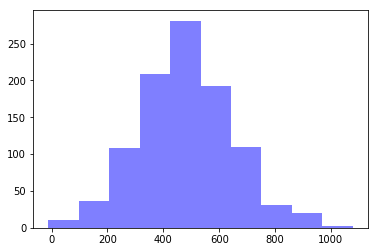

In [44]:
import matplotlib.pyplot as plt
num_bins = 10
plt.hist(user_data['time_on_site'], num_bins, facecolor='blue', alpha=0.5)

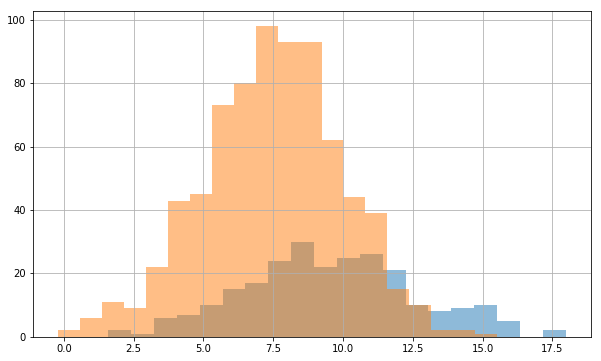

In [45]:
user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6));

In [46]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-11.577286141400918,24.133950193144244,41.663712178575395,51.0142622814501,57.617060493533415,76.7004757581588,78.7519688062111,79.4733571391244,88.66814257823773,95.48469149317611,101.23010874944032,108.44180997873383,110.86684530140684,110.87112841951273,113.09292443521218,114.53316896355449,119.86111318374031,124.19218452037364,128.53933737848502,128.6586862026686,130.13234727197596,138.4838598245276,140.56483626981588,140.76644937496297,148.5020102331669,151.49788647697693,153.5982625276577,164.59249343116488,173.3767157959091,173.41286098735713,177.55053474577556,182.22473563902946,183.91102201422342,184.34011178944712,185.98241861073575,186.6676312809234,186.76447051790575,187.17856151781808,187.31012879187062,187.9184527922469,...,779.6681040831884,786.432230137028,790.2947247123559,790.8052095611945,795.1559032565502,801.3832617390074,805.2737844060097,812.4606531380243,813.3828334345415,813.4986481187768,814.8778709863057,833.9433328942143,835.4431434986147,839.7519602805486,841.3284708015019,845.682401664194,854.5532402999524,864.406306890013,865.537477387149,869.8442150850738,870.438479798162,876.9444237904111,883.8636133909849,884.5411347323983,892.0272127566803,893.9011631648473,907.3276182703904,908.4574111103525,914.9070595118349,919.1276548905275,921.1262784339885,928.1344587579663,930.5844447272798,932.6951614844545,947.3387501037249,948.131707222003,966.5593281526469,975.9412708776877,1062.353458863336,1078.4321583957549
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
True,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,0,0,...,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1


In [47]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='index')

purchased,False,True
time_on_site_min,,
"(-0.211, 3.44]",0.659574,0.340426
"(3.44, 7.074]",0.454259,0.545741
"(7.074, 10.707]",0.393235,0.606765
"(10.707, 14.341]",0.300000,0.700000
"(14.341, 17.974]",0.217391,0.782609


In [48]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.211, 3.44]",0.075980,0.027027
"(3.44, 7.074]",0.352941,0.292230
"(7.074, 10.707]",0.455882,0.484797
"(10.707, 14.341]",0.102941,0.165541
"(14.341, 17.974]",0.012255,0.030405


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased


In [49]:
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.472,0.386667
True,0.528,0.613333


In [50]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')



purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(-0.211, 3.44]    0.033898  0.093103  0.007576  0.032609
(3.44, 7.074]     0.228814  0.403448  0.128788  0.339130
(7.074, 10.707]   0.508475  0.434483  0.409091  0.506522
(10.707, 14.341]  0.186441  0.068966  0.340909  0.115217
(14.341, 17.974]  0.042373  0.000000  0.113636  0.006522

## Stanford Open Police Project

In [51]:
%%time
import pandas as pd
nj_data = pd.read_csv('nj_statewide_2019_02_25.csv')



CPU times: user 1.56 s, sys: 69.1 ms, total: 1.63 s
Wall time: 1.63 s


In [52]:
print(nj_data.shape)
nj_data.head()

(304788, 20)


,raw_row_number,date,time,location,subject_race,subject_sex,officer_id_hash,department_id,type,violation,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state
0,24723,2009-01-10,15:38:41,"31ST / CARMEN, Camden City",black,male,347f40fd4d,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,SIL,Chrysler,Town & Country,NJ
1,88239,2009-02-06,11:34:36,"@division, Ewing Twp",black,female,e84e551aad,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101999,2009-02-11,01:34:26,"34TH / WESTFIELD, Camden City",black,male,e008ccd5a2,A010,vehicular,NaN,True,NaN,NaN,arrest,False,True,GRY,Chevrolet,NaN,PA
3,151289,2009-03-03,20:29:16,"MACARTHUR / 12TH, Camden City",black,male,b84c0f827e,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,BLU,Chevrolet,Tahoe,NJ
4,153223,2009-03-05,22:25:26,"FEDERAL / 10TH, Camden City",black,male,56eb37f85f,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLK,Ford,Expedition,NJ


In [53]:
nj_data.isna().sum()

raw_row_number                     0
date                               0
time                               0
location                           0
subject_race                    1271
subject_sex                      697
officer_id_hash                    0
department_id                      0
type                               0
violation                      64988
arrest_made                   287992
citation_issued                57601
warning_issued                 57646
outcome                        57033
frisk_performed               286878
search_conducted              286355
vehicle_color                   7308
vehicle_make                    7893
vehicle_model                 229560
vehicle_registration_state      1480
dtype: int64

In [54]:
nj_data.violation.value_counts().head(10)

39:4-97 CARELESS DRIVING            66306
39:3-66 MAINTENANCE ILLUM DEVICE    33590
39:4-88B UNSAFE LANE CHANGE         20820
39:4-98 RATES OF SPEED              14498
39:4-99 EXCEED SPEED LIMITATIONS    13581
39:3-76.2F REQ WEARING SEATBELTS    12667
39:3-75 SAFETY GLASS DEFINED         9362
39:3-33 REG PLATES / FICTITIOUS      8777
39:3-40 DRIVE WITHOUT LICENSE        8361
39:3-74 WINDSHIELD WIPERS            7265
Name: violation, dtype: int64

In [55]:
nj_data.vehicle_make.value_counts(normalize=True).head(10)

Ford          0.148713
Chevrolet     0.116893
Honda         0.103370
Nissan        0.080342
Toyota        0.073528
Dodge         0.069142
Hyundai       0.037259
Jeep          0.035413
Chrysler      0.023672
Volkswagen    0.022166
Name: vehicle_make, dtype: float64

In [56]:
nj_data[nj_data.violation == '39:4-98 RATES OF SPEED'].vehicle_make.value_counts(normalize=True).head(10)

Ford         0.142576
Honda        0.103046
Chevrolet    0.098052
Toyota       0.084969
Nissan       0.076106
Dodge        0.062953
Hyundai      0.040304
Jeep         0.030105
Chrysler     0.026025
Acura        0.024900
Name: vehicle_make, dtype: float64

In [57]:
nj_data[nj_data.violation == '39:4-98 RATES OF SPEED'].vehicle_color.value_counts(normalize=True).head(10)

BLK    0.216425
SIL    0.195596
WHI    0.158426
BLU    0.107090
RED    0.092012
GRY    0.080931
GRN    0.061014
TAN    0.031769
GLD    0.019216
MAR    0.011081
Name: vehicle_color, dtype: float64

Use %%timeit to optimize code,
import tqdm

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [58]:
# Import the person.csv dataset
import pandas as pd
person_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)
person_data.head()


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [86]:
# Let's take a look at the data using crosstab
age_bins = pd.cut(person_data['age'], 10)  # 10 equal-sized bins
pd.crosstab(age_bins, person_data['weight'])

weight,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,...,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,233,234,236,237,238,239,240,241,242,244,246
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(17.938, 24.2]",0,2,2,0,1,0,1,1,4,1,1,2,0,1,3,2,3,2,0,3,2,1,1,1,1,2,1,1,1,1,1,2,1,0,0,2,2,1,3,0,...,1,3,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
"(24.2, 30.4]",1,1,3,1,1,2,1,0,2,2,1,2,1,3,2,3,3,2,0,2,0,1,0,1,0,1,1,0,2,0,2,1,1,3,1,0,1,5,1,1,...,1,0,0,0,0,2,1,3,0,0,0,2,0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
"(30.4, 36.6]",1,2,0,0,0,2,4,2,1,1,0,2,1,2,1,0,1,5,2,1,4,0,1,1,5,1,5,1,1,4,0,2,0,2,2,1,0,1,3,0,...,1,2,1,2,0,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0
"(36.6, 42.8]",3,2,2,2,1,2,0,3,2,4,2,0,1,3,0,1,5,1,0,0,2,1,3,1,2,3,1,1,3,2,0,1,0,0,1,1,2,3,2,2,...,2,1,1,0,0,1,2,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
"(42.8, 49.0]",0,1,2,1,3,0,0,0,3,0,2,0,0,2,0,0,1,0,2,2,1,1,1,0,1,3,1,1,5,2,2,2,1,1,0,6,0,6,0,2,...,0,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
"(49.0, 55.2]",1,0,2,1,0,2,0,2,2,2,2,2,0,1,3,1,1,1,1,1,1,3,3,0,1,3,1,4,0,2,1,1,2,0,2,0,0,1,0,1,...,0,3,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
"(55.2, 61.4]",3,0,0,1,0,2,0,2,0,0,1,0,1,2,1,1,1,2,1,0,0,1,1,3,1,3,2,2,1,0,0,0,3,1,2,1,3,0,0,2,...,1,0,1,1,0,2,0,1,0,0,1,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"(61.4, 67.6]",2,2,0,0,0,0,0,1,1,0,0,1,2,1,0,0,0,0,0,0,2,0,1,0,1,0,2,1,4,0,0,2,1,1,3,1,4,1,1,0,...,2,1,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1,0,0,0,1,0,0,0
"(67.6, 73.8]",0,0,0,1,3,0,2,0,3,3,2,1,1,3,1,0,0,0,0,0,0,0,2,2,4,2,2,1,0,1,1,2,0,1,0,0,1,0,2,2,...,0,1,0,0,1,1,2,2,1,0,0,2,0,0,0,1,0,1,0,1,0,0,1,1,0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0


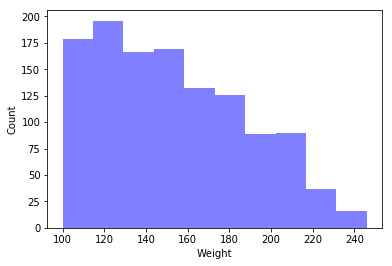

In [60]:
# Let's plot a histogram of the data to look for patterns - weight first
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 10
plt.hist(person_data['weight'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

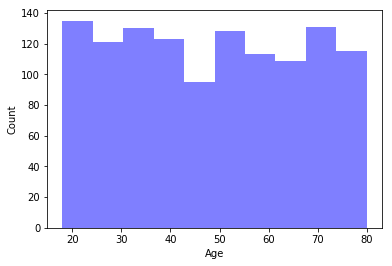

In [61]:
# Let's plot a histogram of the data to look for patterns - age next
num_bins = 10
plt.hist(person_data['age'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

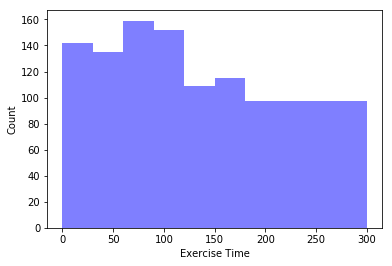

In [62]:
# Let's plot a histogram of the data to look for patterns - exercise time
num_bins = 10
plt.hist(person_data['exercise_time'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Exercise Time')
plt.ylabel('Count')
plt.show()

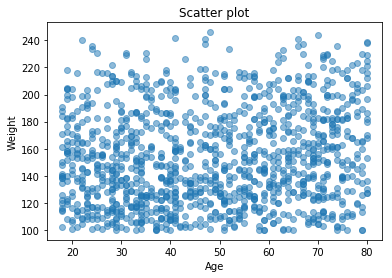

In [63]:
# A scatter plot should show if a trend exists - check age and weight
plt.scatter(person_data['age'], person_data['weight'], alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.show()

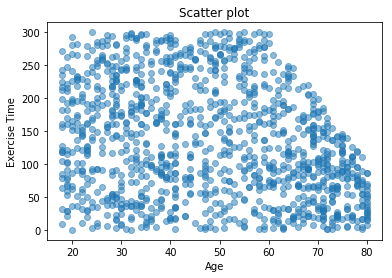

In [64]:
# A scatter plot should show if a trend exists - check age and exercise time
plt.scatter(person_data['age'], person_data['exercise_time'], alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('Age')
plt.ylabel('Exercise Time')
plt.show()

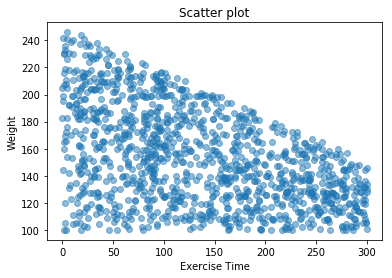

In [65]:
# A scatter plot should show if a trend exists - exercise time and weight
plt.scatter(person_data['exercise_time'], person_data['weight'], alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('Exercise Time')
plt.ylabel('Weight')
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

They are all integer data types.

2.  What are the relationships between the variables?

Age and Weight are randomly distributed, no specific relationship appears to exist.

Exercise Time does appear to decline starting around 60 years old.

Weight does appear to fall with an increase in Exercise Time.

3.  Which relationships are "real", and which spurious?

Exercise Time and Age are "real",
Weight and Exercise Time are "real",
Age and Weight are spurious


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

In [0]:
# See the last cell for the Spurious Correlation

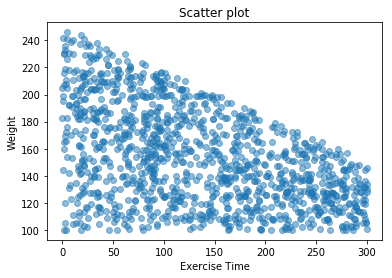

In [91]:
# Picked linear regression to plot the relationship between Exercise Time and Weight
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Use linear regression model
model = LinearRegression()

# Show scatter plot of data
plt.scatter(person_data['exercise_time'], person_data['weight'], alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('Exercise Time')
plt.ylabel('Weight')
plt.show()

In [92]:
# Show actual data
person_data.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


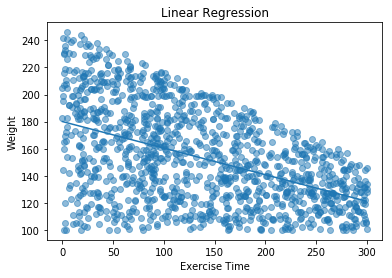

(array([-0.196308]), 180.0249092565172)

In [134]:
# Run the linear regreassion
from sklearn.linear_model import LinearRegression
features = ['exercise_time'] # Set features to exercise time
target = 'weight'            # Set target to weight

model = LinearRegression()
model.fit(person_data[features], person_data[target])

# create values to predict using the exercise range
exercise_time = [[w] for w in range(0, 300)]

# make predictions based on linear regression model
predictions = model.predict(exercise_time)

# graph it all
plt.scatter(person_data['exercise_time'], person_data['weight'], alpha=0.5)
plt.plot(exercise_time, predictions)
plt.title('Linear Regression')
plt.xlabel('Exercise Time')
plt.ylabel('Weight')
plt.show()

# Show the y = -.19x + 180 linear regression line values
model.coef_, model.intercept_

In [160]:
# Import the auto-mpg.csv dataset for a spurious correlation
import pandas as pd
car_data = pd.read_csv('auto-mpg.csv')
car_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [161]:
convert_dict = {'mpg': int}
car_data = car_data.astype(convert_dict)
car_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17,8,302.0,140,3449,10.5,70,1,ford torino


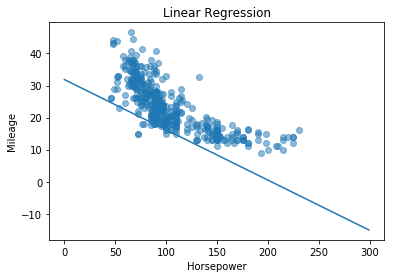

(array([-0.15682197]), 39.68946548479943)

In [162]:
# Run the linear regression
from sklearn.linear_model import LinearRegression
features = ['horsepower'] # Set features to horsepower
target = 'mpg'            # Set target to mileage

model = LinearRegression()
model.fit(car_data[features], car_data[target])

# create values to predict using the horsepower range
horsepower_values = [[w] for w in range(50, 350)]

# make predictions based on linear regression model
predictions = model.predict(horsepower_values)

# graph it all
plt.scatter(car_data['horsepower'], person_data['mpg'], alpha=0.5)
plt.plot(exercise_time, predictions)
plt.title('Linear Regression')
plt.xlabel('Horsepower')
plt.ylabel('Mileage')
plt.show()

# Show the y = -.19x + 180 linear regression line values
model.coef_, model.intercept_

## Spurious Correlation!

Weight and Exercise correlates with Horsepower and Mileage!